In [69]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# train test split
from sklearn.model_selection import train_test_split
#logistic regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns 


In [70]:
np.random.seed(42)
(train_pool_X, train_pool_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
train_X, Pool_X, train_y,  Pool_y = train_test_split(train_pool_X, train_pool_y, train_size=50, random_state=42)
print(train_X.shape, Pool_X.shape, train_y.shape, Pool_y.shape, test_X.shape, test_y.shape)


(50, 28, 28) (59950, 28, 28) (50,) (59950,) (10000, 28, 28) (10000,)


In [71]:
train_pool_X = train_pool_X.reshape(train_pool_X.shape[0], -1)
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
Pool_X = Pool_X.reshape(Pool_X.shape[0], -1)
print(train_pool_X.shape, train_X.shape, test_X.shape, Pool_X.shape)

(60000, 784) (50, 784) (10000, 784) (59950, 784)


In [72]:
model = RandomForestClassifier()


Accuracy:  0.6109
rmse =  2.387488219866226


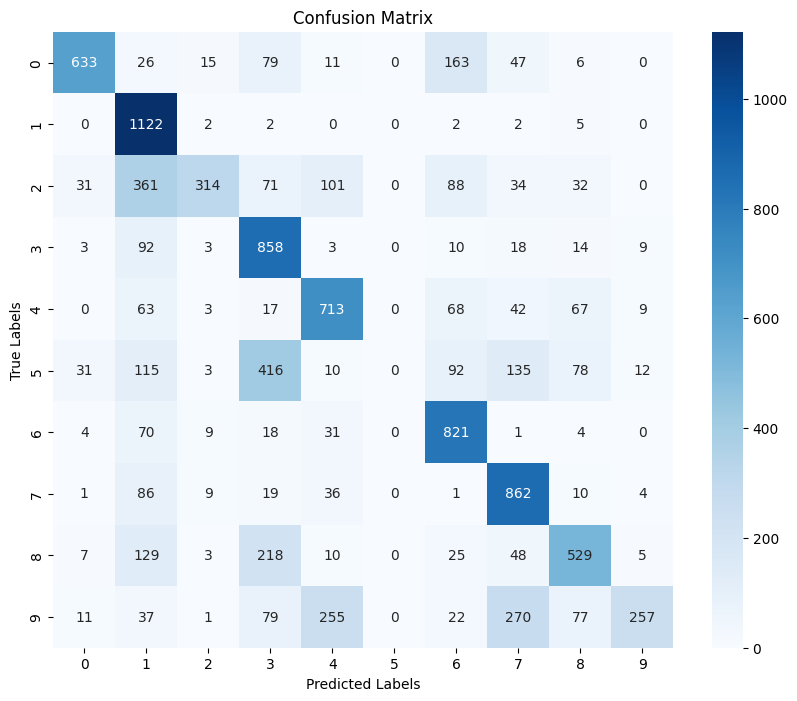

In [73]:
model.fit(train_X, train_y)
y_pred=model.predict(test_X)
print("Accuracy: ", accuracy_score(test_y, y_pred))
print("rmse = ", np.sqrt(mean_squared_error(test_y, y_pred)))
cm= confusion_matrix(test_y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels');

In [74]:
def entropy(p, epsilon=1e-7):
    p = np.clip(p, epsilon, 1.0 - epsilon)  
    return -np.sum(p * np.log2(p), axis=1)

In [75]:
def margin_sampling(probabilities):
    sorted_probs = np.sort(probabilities, axis=1)
    return sorted_probs[:, -1] - sorted_probs[:, -2]

In [76]:
def least_confident(probabilities):
    return 1 - np.max(probabilities, axis=1)

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

def active_learning(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test, acquisition_function, num_iterations=10, number_of_sample=1):
    newly_added_X = np.empty((0, pool_X_train.shape[1]))  
    newly_added_y = np.array([])
    rmse_loss = []

    for _ in range(num_iterations):
        model = RandomForestClassifier()
        model.fit(train_X, train_y)
        pool_probabilities = model.predict_proba(pool_X_train)
        acquisition_scores = acquisition_function(pool_probabilities)
        selected_indices = np.argsort(acquisition_scores)[-number_of_sample:]
        labeled_X = pool_X_train[selected_indices]
        labeled_y = pool_y_train[selected_indices]

        train_X = np.concatenate((train_X, labeled_X), axis=0)
        train_y = np.concatenate((train_y, labeled_y), axis=0)
        pool_X_train = np.delete(pool_X_train, selected_indices, axis=0)
        pool_y_train = np.delete(pool_y_train, selected_indices)

        newly_added_X = np.concatenate((newly_added_X, labeled_X), axis=0)
        newly_added_y = np.concatenate((newly_added_y, labeled_y), axis=0)

        y_pred = model.predict(pool_X_test)

        accuracy = accuracy_score(y_test, y_pred)
        rmse_score = np.sqrt(mean_squared_error(train_y, model.predict(train_X)))
        # print("RMSE score and Accuracy score after iteration {}: {:.4f} {:.4f}".format(_ + 1, rmse_score, accuracy))

        rmse_loss.append(rmse_score)

    return train_X, train_y, newly_added_X, newly_added_y, rmse_loss


In [78]:
train_X_least_entropy, train_y_least_entropy, newly_added_X_entropy, newly_added_y_entropy, rmse_loss_least_entropy = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,
                                                                                                 acquisition_function=entropy,
                                                                                                 num_iterations=20,
                                                                                                 number_of_sample=1)

In [79]:
train_X_least_margin, train_y_least_margin, newly_added_X_margin, newly_added_y_margin, rmse_loss_least_margin = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,
                                                                                                 acquisition_function=margin_sampling,
                                                                                                 num_iterations=20,
                                                                                                 number_of_sample=1)

In [80]:
train_X, train_y, newly_added_X, newly_added_y, rmse_loss = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,acquisition_function=least_confident,
                                                                             num_iterations=20,
                                                                             number_of_sample=1)

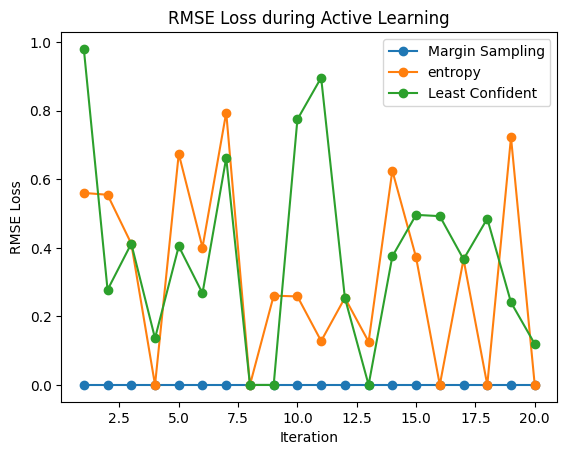

In [81]:
plt.plot(range(1, len(rmse_loss_least_margin) + 1), rmse_loss_least_margin, marker='o',label='Margin Sampling')
plt.plot(range(1, len(rmse_loss_least_entropy) + 1), rmse_loss_least_entropy,marker='o', label='entropy')
plt.plot(range(1, len(rmse_loss) + 1), rmse_loss, marker='o',label='Least Confident')
plt.xlabel('Iteration')
plt.ylabel('RMSE Loss')
plt.title('RMSE Loss during Active Learning')
plt.legend();